# Titanic Survival Classifier

In this project a dataset containing several pieces of information from titanic passengers will be analyzed in order to try to predict whether or not they survived the Titanic's maiden voyage. For this reason several machine learning algorithms will be constructed and their efficacy will be tested.

In addition a Kaggle workflow will be created, since this is a very popular [competition](https://www.kaggle.com/c/titanic) on the [Kaggle website](https://www.kaggle.com/). In a Kaggle competition, the competitor is given a dataset to train and test their machine learning model on. In addition, they are given a second, unlabeled dataset on which to make predictions. The user's models are used to predict the labels on the unlabeled dataset. These labels are then submitted to Kaggle and graded on their accuracy. Each competitor is given the chance to keep submitting more results in order to improve their score and standings on the leaderboard. Often many submissions are made as the models are improved iteratively, so it is a good idea to automate the workflow of training and testing a model and then finalizing a submission.

# Setup

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [2]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

The train dataset features 12 columns containing the information of 891 passengers:

* `PassengerId`: Unique identifier for each passenger
* `Survived`: 0 if passenger perished when the Titanic sank, 1 if they survived
* `Pclass`: passenger's ticket class 1-3
* `Name`: passenger name
* `Sex`: male or female
* `Age`
* `SibSp`: Number of siblings and spouses on board
* `Parch`: Number of parents and children on board
* `Ticket`: ticket identifier. Could possibly contain additional pieces of information
* `Fare`: price paid for the ticket
* `Embarked`: identifier for the port the passenger got onto the titanic

In [4]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The holdout set of the data has different passengers and is missing the `Survived` column, which contains the information of whether the passenger survived or not, because this is the target column.

## Data Preprocessing:

These are functions previously created, that will help process the data. They will allow for an automated data processing process, making it possible to easily apply the same preprocessing steps to all of the datasets.

In [5]:
def process_missing(df):
    """Handle various missing values in the data set
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: Processed dataset
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Function to apply all of the preprocessing:

In [6]:
def apply_functions(df):
    '''Apply all preprocessing steps to a dataset
    Args:
        df(pandas.DataFrame): dataset to process
    Returns:
        pandas.DataFrame: processed dataset
    '''
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for column in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df, column)
    return df

Applying the preprocessing can be done by running:

`train = apply_functions(train)
holdout = apply_functions(holdout)`

but first some new features can be engineered. The preprocessing can then be applied to all features.

## Feature Engineering:

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

To find possible new features, gaining an overview over the data by making histograms for different columns could help:

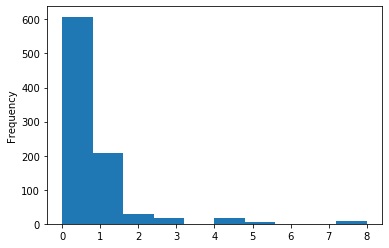

In [8]:
train.SibSp.plot.hist()

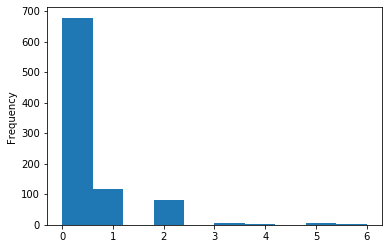

In [9]:
train.Parch.plot.hist()

Most people on the Titanic were there without their families

Pivot tables to find possible connections between family size and survival rate

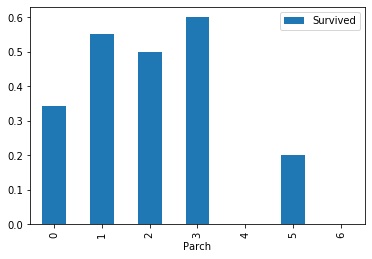

In [10]:
train.pivot_table(values = 'Survived', index = ['Parch']).plot.bar()

people with no parents or children have a lower survival rate than those with family on board. This does not hold up for people with 5 parents or children.

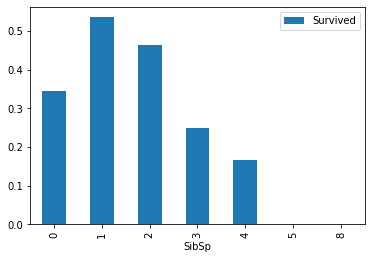

In [11]:
train.pivot_table(values = 'Survived', index = 'SibSp').plot.bar()

Having siblings and/or a spouse on board also seems to increase the survival probability for 1 or 2 such family members. After this the survival probability decreases drastically.

The question now is if these trends carry over when looking at the total size of the family:

In [12]:
fam_cols = train[['SibSp', 'Parch', 'Survived']].copy()

fam_cols['tots'] = fam_cols['SibSp'] + fam_cols['Parch']

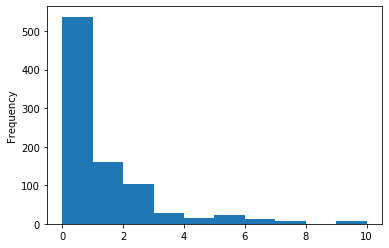

In [13]:
fam_cols.tots.plot.hist()

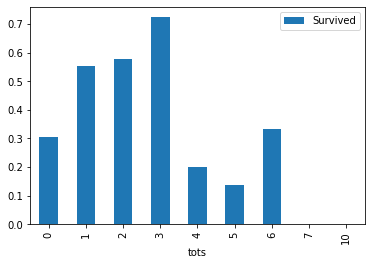

In [14]:
fam_cols.pivot_table(values = 'Survived', index = 'tots').plot.bar()

Having a small family on board increases survival probability.
Survival probability has a maximum at 3 family members on board.
Four or more family members sharply reduce survival probability.
Combining the different column might be a good idea to engineer a new feature. The individual columns behave very similarly to their total, which implies that it is probably not important if a family member belonged to the group parent/child or sibling/spouse.

## Engineering New Feature:

In [15]:
train['famsize'] = train.Parch + train.SibSp
holdout['famsize'] = holdout.Parch + holdout.SibSp

To improve this feature either:

* Change it into a binary feature
* Make three groups of people

The second choice seems to be the better one, because the previous analysis showed that larger families are at a disadvantage for survival when compared to small families. This information would be lost in a feature that only shows if someone was alone or not. 

On the other hand, the group traveling alone makes up a large majority of the total population. This could be helpful information to some of the models.

In [16]:
def make_alone(df):
    '''Make a feature stating if someone traveled alone or with family
    Args:
        df(pandas.DataFrame): dataframe to add feature to
    Return:
        pandas.DataFrame: dataframe with added feature
    '''
    df.loc[df.famsize == 0, 'alone'] = 1
    df.loc[df.famsize != 0, 'alone'] = 0
    return df

In [17]:
train = make_alone(train)
holdout = make_alone(holdout)

In [18]:
def mk_fsd(df):
    '''Create new feature catigorizing family size:
        0   - alone
        1-3 - small
        > 3 - large
    Args:
        df(pandas.DataFrame): dataframe to add feature to
    Return:
        pandas.DataFrame: dataframe with added feature
    '''
    df.loc[df.famsize == 0, 'famsize_disc'] = 'alone'
    df.loc[(df.famsize > 0) & (df.famsize < 4), 'famsize_disc'] = 'small'
    df.loc[df.famsize >= 4, 'famsize_disc'] = 'large'
    df = create_dummies(df,'famsize_disc')
    return df    

In [19]:
train = mk_fsd(train)
holdout = mk_fsd(holdout)

with the new features in place, the preprocessing steps have to be applied:

In [31]:
train_original = train.copy()
holdout_original = holdout.copy()
train = apply_functions(train)
holdout = apply_functions(holdout)

Now it is important, that both the `train` and `holdout` set contain the same columns, because otherwise models trained on the `train` dataset would not necessarily be applicable to `holdout`:

In [ ]:
for column in holdout.columns:
    if (column not in train.columns):
        print(str(column) + ' is in holdout, but not in train')
for column in train.columns:
    if (column not in holdout.columns):
        print(str(column) + ' is in train, but not in holdout')

The column `Survived` is excluded from the holdout so that the contestants in the competition do not have access to the results. The only other discrepancy is the `Cabin_type_T` column. The reason for the discrepancy can be seen when looking at the datasets before applying the functions:

In [34]:
print(train_original.Cabin.str[0].value_counts())
print(holdout_original.Cabin.str[0].value_counts())

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64
C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: Cabin, dtype: int64


The holdout dataset did not contain a single passenger in a cabin with the type T. This seems o be a very rare cabin type, because there is only one in the complete dataset. Maybe these are the captain's quarters. Due to the small variability in the column `Cabin_type_T` caused by there only being one 1 value and the rest all being 0s it would be the best course of action to just drop this column from the train set, since it is unlikely to contribute to the accuracy of any of the machine learning models:

In [36]:
train.drop(columns = ['Cabin_type_T'], inplace = True)

## Feature selection

Making a function to use the Recursive Feature Elimination with Cross-Validation (RFECV) algorithm in sklearn:

In [37]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [38]:
def select_features(df, estimator = RandomForestClassifier(random_state = 1, n_jobs = -1)):
    '''Select best features
    Args:
        df(pandas.DataFrame): dataset from which to select features
        estimator = RandomForest_Classifier(random_state = 1, n_jobs = -1): machine learning model to use
    Returns:
        list(str): list containing the best performing features.
    '''
    all_X = df.select_dtypes(exclude = ['object', 'category']).drop(columns = ['Survived', 'PassengerId']).dropna(axis = 1)
    all_y = df.Survived

    est = estimator

    selector = RFECV(est, cv = 10, n_jobs = 4)
    selector.fit(all_X, all_y)
    columns = all_X.columns[selector.support_]
    print(columns)
    return columns

In [39]:
best_cols = select_features(train, RandomForestClassifier(random_state = 1, n_jobs = -1))
all_X = train[best_cols]
all_y = train.Survived


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'famsize', 'alone',
       'famsize_disc_alone', 'famsize_disc_large', 'famsize_disc_small',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male'],
      dtype='object')


## Model Selection and Tuning:

Next the `sklearn.model_selection.GridSearchCV` algorithm will be used to determine the best model as well as its settings for the data:

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

Making a list of model dictionaries, to be able to automate the grid search. The list will contain the model names, as well as some important settings for each model

In [41]:
model_dics = [{
    'name': 'KNeighborsClassifier',
    'estimator': KNeighborsClassifier(n_jobs = -1),
    'hyperparameters':
    {
        'n_neighbors': range(1,20, 2),
        'weights': ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1,2]
    }
},
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(n_jobs = -1),
        'hyperparameters': 
        {
            'solver' : ['newton-cg', 'ldfgs', 'liblinear']    
    }
    },
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(random_state = 1, n_jobs = -1),
        'hyperparameters':
        {
            'n_estimators' : [4, 6, 9, 100],
            'criterion': ['entropy', 'gini'],
            'max_depth': [2, 5, 10],
            'max_features': ['log2', 'sqrt'],
            'min_samples_leaf': [1, 5, 8],
            'min_samples_split': [2, 3, 5]
        }
    },
    {
        'name': 'MLPClassifier',
        'estimator': MLPClassifier(random_state = 1),
        'hyperparameters':
        {
            'hidden_layer_sizes': [(10,), (20,), (30,), (50, 50), (20,20,20,20,20), (512, 256)],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'max_iter': [100, 1000, 10000],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
            
        }
    }
]

In [42]:
def select_model(df, model_dic):
    '''Select the correct model using the grid-search algorithm:
    Args:
        df(pandas.DataFrame): dataframe to apply the model to
        model_dic: dictionary containing the information of each model and the values
        to try during the gridsearch
    Returns:
        best performing parameters, best performing trained model
    '''
    est = model_dic['estimator']
    hp = model_dic['hyperparameters']
    grid = GridSearchCV(estimator = est, n_jobs = -1, param_grid = hp, cv = 10)
    grid.fit(all_X, all_y)
    print(model_dic['name'])
    print(grid.best_params_)
    print(grid.best_score_)
    return grid.best_params_, grid.best_estimator_

In [43]:
for model in model_dics:
    results = select_model(train, model)
    model['best_params'] = results[0]
    model['best_est'] = results[1]

KNeighborsClassifier
{'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.7845318352059926
LogisticRegression
{'solver': 'newton-cg'}
0.823832709113608
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.8384019975031209
MLPClassifier
{'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
0.8170786516853932


The model with the highest accuracy is the random forest classifier. The Logistic Regression and multi-layer perceptron are very close in score. Now a function will be created to be able to make submissions to Kaggle:

In [52]:
def make_predictions(df, modelnr):
    '''Make predictions on a dataset using the best settings detected in the grid search
    Args:
        df (pandas.DataFrame): dataframe to make predictions on
        modelnr (int): index of the model in model_dics
    Returns:
        .CSV file predictions based on a model in the models dictionary, in the right formating
        to be used as a Kaggle submission
    '''
    predictions = model_dics[modelnr]['best_est'].predict(df[best_cols])
    pred_df = pd.DataFrame(
        {
            'PassengerID' : df.PassengerId,
            'Survived' : predictions
        }
    )
    pred_df.to_csv('submission.csv', index = False)

The random forest model will be used first, since it performed the highest:

In [53]:
make_predictions(holdout, 2)

In [54]:
pd.read_csv('submission.csv')

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### RF:
The random forest model achieved an accuracy score of 0.79425 on Kaggle, which is very close to what it achieved when tested on the train model. But because two other models scored very close to the same accuracy as the random forest, they will also be used to make submissions to Kaggle. First off, the linear regression model will be used:

In [57]:
make_predictions(holdout, 1)

### LR:
The linear regression model scored 0.77511, which is slightly worse than that of the random forest. Next, the multi-layer perceptron will be tested:

In [58]:
make_predictions(holdout, 3)

### MLP:

The multi-layer preceptron achieved a score of 0.78468, which is better than the linear regression model and worse than the random forest model. This is what is expected from the accuracy scores the models achieve when applied to the train set.

# Summary:

In this project four different machine learning models were used to predict whether or not different passengers of the Titanic would survive the trip: a k-nearest neighbors classifier, a linear regression classifier, a random forest classifier and a multi-layer perceptron. The last three of these performed very similarly when applied to the train set at an accuracy score of 81% - 83%. The k-nearest neighbors model performed worse at 78%.The highest scoring model was the random forest.

The three models were then used to create submissions for the Kaggle competition based on the dataset. Here they all performed very similarly as when applied on the train set. Again the random forest model performed the best by a slight margin at 79.4% accuracy.

# Addendum:

## MLP in Tensorflow

Here I attempted to make a multi-layer perceptron in Tensorflow from scratch to achieve the same result as the mlp model using sklearn. This was done, so I could understand the way neural networks work from the ground up. Unfortunately as of writing this it is not converging. I may come back to this in the future, as I learn more about neural networks and understand what is going wrong. If I get it to work, I will also improve the documentation.

In [59]:
import keras
from sklearn.preprocessing import LabelBinarizer
import os
os.environ['TF_MIN_GPU_MULTIPROCESSOR_COUNT']='4'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import tensorflow.compat.v1 as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.InteractiveSession()
tf.disable_eager_execution()

Using TensorFlow backend.


Normalizing the selected features from all_X and holdout

In [60]:
from sklearn.preprocessing import normalize
tf_X = normalize(all_X[best_cols], axis = 0)
tf_X = tf_X.astype(np.float32)
tf_X_test = tf_X[-200:]
tf_X = tf_X[:-200]
print(tf_X.shape, tf_X_test.shape)
tf_holdout = normalize(holdout[best_cols], axis = 0)

(691, 32) (200, 32)


turning the labels into a one-hot encoded vector:

In [61]:
lb = LabelBinarizer()
tf_y = lb.fit_transform(all_y)
tf_y = tf_y.astype(np.float32)
tf_y_test = tf_y[-200:]
tf_y = tf_y[:-200]

The model will at first have the proportions: 
#features(input) - 512(hidden layer 1) - 256(hidden-layer 2) - 1(Output)

In [62]:
num_classes = 1
num_features = tf_X.shape[1]
num_output = 1
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1

Placeholders for  Tensorflow

In [63]:
input_X = tf.placeholder('float32', shape = (None, num_features), name = 'input_X')
input_y = tf.placeholder('float32', shape = (None, num_classes), name = 'input_y')
# for dropout
keep_prob = tf.placeholder(tf.float32)

Initializing the dense layers with a random normal distribution with zero meand and a small vaiance (1/sqrt(number of features))

In [64]:
weights_0 = tf.Variable(tf.random_normal([num_features, num_layers_0], stddev = 1/tf.sqrt(float(num_features))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))

weights_1 = tf.Variable(tf.random_normal([num_layers_0, num_layers_1], stddev = 1/tf.sqrt(float(num_layers_0))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))

weights_2 = tf.Variable(tf.random_normal([num_layers_1, num_output], stddev = 1/tf.sqrt(float(num_output))))
bias_2 = tf.Variable(tf.random_normal([num_output]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Beginning the graph calculation:

1. multiply the input for each layer with its weights
2. add the biases
3. activation function (for the hidden layers the relu function will be used, the output layers will use a sigmoid function, to produce a probability score to assign each passenger to either 1(survived) or 0(perished))
4. using dropout regularization to reduce overfitting. Dropout randomly selects features in the layers it is used on th train a new model. This decreases model complexity and specialization and in turn overfitting.

In [65]:
# Initializing weights and biases:
hidden_output_0 = tf.nn.relu(tf.matmul(input_X, weights_0) + bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)

hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0, weights_1) + bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)

predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1, weights_2) + bias_2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Loss function and regularization:

The loss function used will be softmax cross entropy with logits. Loss functions give the model a value to minimize, which is the goal telling the model it is converging.

Additional measure against overfitting, regularisation:
Additional term is added to the loss function:
    -> reduces the values in weight functions
    -> results in simpler models and reduces ovefitting
L2 regularization will be used, which punishes large values in the weight matrices quadratically

In [66]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = predicted_y, labels = input_y)) \
+ regularizer_rate * (tf.reduce_sum(tf.square(bias_1)))

Optimizer and Learning rate: 
Exponential decay will be used to reduce the learning rate by 15% every five epochs.
The Adam optimizer will be used

In [67]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase = True)
## Adam optimizer for finding the right weights
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list = [weights_0 , weights_1, weights_2,
                                                                             bias_0, bias_1, bias_2])

## Accuracy metric

In [68]:
## Metrics definition
correct_prediction = tf.equal(tf_y, predicted_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## Training the Network:
batch optimization size 128 and train for 14 epochs

In [69]:
import time
t0 = time.time()
## Training parameters
batch_size = 16
epochs = 14
dropout_prob = 0.6

training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())
for epoch in range(epochs):
    arr = np.arange(tf_X.shape[0])
    np.random.shuffle(arr)
    for index in range(0, tf_X.shape[0], batch_size):
        s.run(optimizer, {input_X: 
                         tf_X[arr[index:index+batch_size]],
                         input_y:
                         tf_y[arr[index:index+batch_size]],
                         keep_prob: dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict = {input_X: tf_X,
                                                             input_y: tf_y,
                                                             keep_prob: 1}))
    training_loss.append(s.run(loss, {input_X: tf_X,
                                         input_y: tf_y,
                                         keep_prob: 1}))
    testing_accuracy.append(accuracy_score(tf_y_test, s.run(predicted_y, {input_X: tf_X_test,
                                                                                    keep_prob:1})))
    print('Epoch{0}. Train loss: {1:.2f} Train acc: {2:.3f},test acc: {3:.3f}'.format(epoch, 
                                                                                            training_loss[epoch],
                                                                                           training_accuracy[epoch],
                                                                                          testing_accuracy[epoch]))

Epoch0. Train loss: 24.93 Train acc: 0.612,test acc: 0.630
Epoch1. Train loss: 23.32 Train acc: 0.612,test acc: 0.630
Epoch2. Train loss: 21.83 Train acc: 0.612,test acc: 0.630
Epoch3. Train loss: 20.44 Train acc: 0.612,test acc: 0.630
Epoch4. Train loss: 19.15 Train acc: 0.612,test acc: 0.630
Epoch5. Train loss: 17.94 Train acc: 0.612,test acc: 0.630
Epoch6. Train loss: 16.82 Train acc: 0.612,test acc: 0.630
Epoch7. Train loss: 15.77 Train acc: 0.612,test acc: 0.630
Epoch8. Train loss: 14.78 Train acc: 0.612,test acc: 0.630
Epoch9. Train loss: 13.87 Train acc: 0.612,test acc: 0.630
Epoch10. Train loss: 13.01 Train acc: 0.612,test acc: 0.630
Epoch11. Train loss: 12.20 Train acc: 0.612,test acc: 0.630
Epoch12. Train loss: 11.45 Train acc: 0.612,test acc: 0.630
Epoch13. Train loss: 10.74 Train acc: 0.612,test acc: 0.630
